# Distribution Similarity

You may want to test the stability of a feature in your model over time.

Does the feature data from 2016-2018 that you used to train your model still describe your latest data from 2019, or has the feature population changed, requiring you to update your model?

With `probatus.stat_tests` you can use different statistical tests to evaluate if the distributions of your data have changed.

## Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import pytest
import probatus
from probatus.binning import AgglomerativeBucketer, SimpleBucketer, QuantileBucketer
from probatus.stat_tests import psi

Let's define some test distributions and visualize them. For these examples, we will use a normal distribution and a shifted version of the same distribution.

In [2]:
counts = 1000
np.random.seed(42)
d1 = np.random.normal(size=counts)
d2 = np.random.normal(loc=0.5, size=counts)

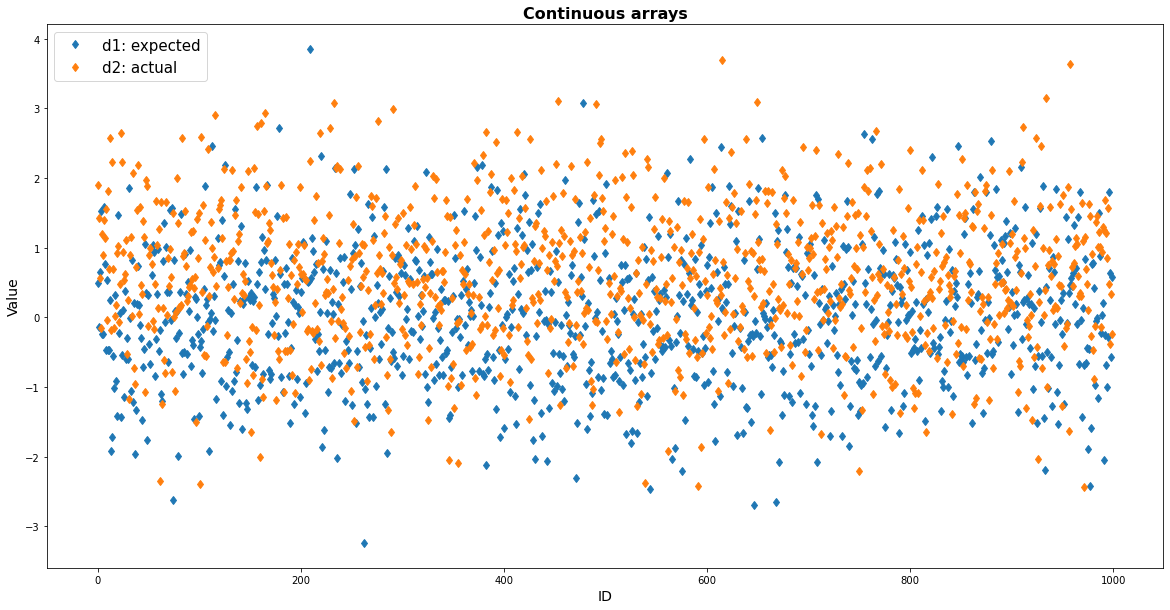

In [3]:
plt.figure(figsize=(20,10))
plt.plot(d1, 'd', label='d1: expected')
plt.plot(d2, 'd', label='d2: actual')
plt.xlabel("ID", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize = 15)
plt.title('Continuous arrays', fontsize=16, fontweight='bold')
plt.show()

### Binning - QuantileBucketer

We will bin the data using a quantile bucketer, available in the `probatus.binning` module.

In [4]:
bins = 10
myBucketer = probatus.binning.QuantileBucketer(bins)
myBucketer.fit(d1)
d1_bincounts_, d1_boundaries_ = probatus.binning.QuantileBucketer(bins).quantile_bins(d1, bins, inf_edges=True)
d1_bincounts = myBucketer.fit_compute(d1)
d2_bincounts = myBucketer.compute(d2)

print("Number of bins:")
print(len(d1_bincounts_), end="\n\n")

print("Bincounts for d1 and d2:")
print(d1_bincounts)
print(d2_bincounts, end="\n\n")

print("Boundaries for bins:")
print(d1_boundaries_)

Number of bins:
10

Bincounts for d1 and d2:
[100 100 100 100 100 100 100 100 100 100]
[ 36  49  48  70  83  76 118 117 173 230]

Boundaries for bins:
[       -inf -1.24476311 -0.80348147 -0.5233581  -0.24068966  0.02530061
  0.24868583  0.51398182  0.81351115  1.3056452          inf]


Let's plot the distribution for which we will calculate the statistics.

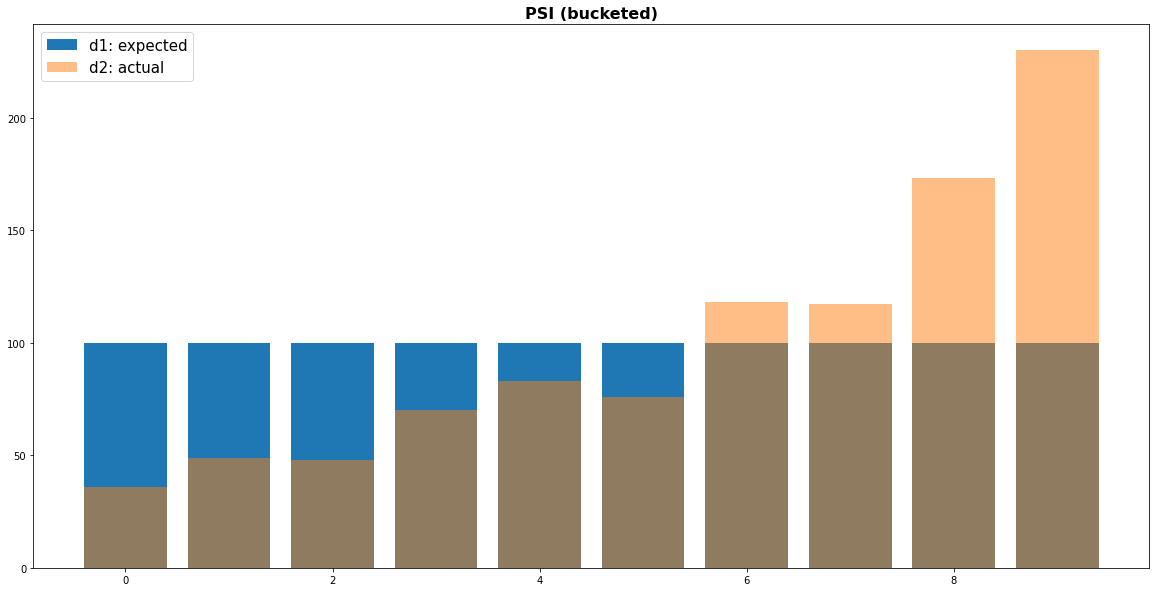

In [5]:
plt.figure(figsize=(20,10))
plt.bar(range(0, len(d1_bincounts)), d1_bincounts, label='d1: expected')
plt.bar(range(0, len(d2_bincounts)), d2_bincounts, label='d2: actual', alpha=0.5)
plt.title('PSI (bucketed)', fontsize=16, fontweight='bold')
plt.legend(fontsize=15)
plt.show()

## PSI
The population stability index ([Karakoulas, 2004](https://cms.rmau.org/uploadedFiles/Credit_Risk/Library/RMA_Journal/Other_Topics_(1998_to_present)/Empirical%20Validation%20of%20Retail%20Credit-Scoring%20Models.pdf)) has long been used to evaluate credit-scoring models.

Advantages:
* Industry (banking / risk modeling) standard

Disadvantages:
* Requires discrete distribution.
* Strong dependence on number of bins. More bins -> higher PSI
* Not very sensitive to extrema bins.
* Does not return p-value.
* Test statistic (TS; in this case, the PSI value) is difficult to interpret, i.e. to define critical values that indicate action required or not.

10-20 bins are typically used

In [6]:
psivalue = probatus.stat_tests.psi(d1_bincounts, d2_bincounts, verbose=True)


PSI = 0.31432662909735887

PSI: Critical values defined according to de facto industry standard:
PSI > 0.25: Significant distribution change; investigate.

PSI: Critical values defined according to Yurdakul (2018):
99.9% confident distributions have changed.


### Smarter PSI
As seen above, probatus evaluates the null hypothesis according to Yurdakul (2018), this is done because:
* Industry-standard PSI critical values of 0.1 and 0.25 are unreliable heuristics because there is a strong dependency on sample sizes and number of bins.
* Aside from these heuristics, the PSI value is not easily interpretable in the context of common statistical frameworks (like a p-value or confidence levels).

[Yurdakul 2018](https://scholarworks.wmich.edu/cgi/viewcontent.cgi?article=4249&context=dissertations) calculate the expectation and variance of PSI, in terms of sample sizes and number of bins, and based on a normal approximation, which allows a practical test to be defined with critical values determined by standard probability percentiles (or z-scores).

In [7]:
n = len(d1)
m = len(d2)
b = bins
alpha = [0.95, 0.99, 0.999]
z_alpha = stats.norm.ppf(alpha)

In [8]:
PSI_critvals = ((1 / n) + (1 / m)) * (b - 1) + z_alpha * ((1 / n) + (1 / m)) * np.sqrt(2 * (b - 1))
PSI_critvals

array([0.03195705, 0.03773972, 0.04422149])

## KS: Kolmogorov-Smirnov
The Kolmogorov-Smirnov test compares two distributions by calculating the maximum difference of the two samples' distribution functions, as illustrated by the black arrow in the following figure. The KS test is available in `probatus.stat_tests.ks`.

<img align="middle" src="KS2_Example.png" alt="Example of the Kolmogorov-Smirnov value" width="400" height="400">

Advantages:
* Sensitive to differences in both location and shape of the empirical cumulative distribution functions of the two samples.

Disadvantages:
* Only works for continuous distributions (unless modified, e.g. see [Jeng 2006](https://bmcmedresmethodol.biomedcentral.com/track/pdf/10.1186/1471-2288-6-45)).
* In large samples, small and unimportant differences can be statistically significant ([Taplin & Hunt 2019](https://www.mdpi.com/2227-9091/7/2/53/pdf)).
* In small samples, large and important differences can be statistically insignificant ([Taplin & Hunt 2019](https://www.mdpi.com/2227-9091/7/2/53/pdf)).

In [9]:
ks, pvalue = probatus.stat_tests.ks(d1_bincounts, d2_bincounts, verbose=True)


KS: pvalue = 0.05244755244755244

KS: Null hypothesis cannot be rejected. Distributions not statistically different.
